**Импорт необходимых библиотек**

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm
from urllib.parse import urlparse
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import(
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report, 
    confusion_matrix,
)
from seaborn import (
    heatmap, 
    barplot, 
    countplot, 
    set_style,
    color_palette,
    set_palette,
    histplot
)

Для красоты

In [2]:
warnings.filterwarnings("ignore")

def get_gradient_palette(cmap, n_colors):
    return [cmap(i/n_colors) for i in range(n_colors)]

colors = ["#fd7e14", "#495057"]
gradient_cmap = LinearSegmentedColormap.from_list("orange_black_grad", colors, N=256)

set_style("whitegrid")
palette = color_palette("rocket");

**Загружаем данные**

In [3]:
train = pd.read_csv("Data/train.csv")

Посмотрим на наш датасет

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     64000 non-null  object
 1   result  64000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1000.1+ KB


In [5]:
train.describe()

,result
count,64000.000000
mean,0.374797
std,0.484074
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
train.head()

,url,result
0,https://caseforpages1885777.web.app/,1
1,https://www.tu-auto.com/,0
2,http://www.bancm.co/desbloqueos/USERscis=login...,1
3,https://doccomo.ne.uqag.xyz,1
4,http://academics.smcvt.edu/sburks/Definition_s...,0


In [7]:
train.shape

(64000, 2)

In [8]:
train = train.drop_duplicates()

In [9]:
train.shape

(63902, 2)

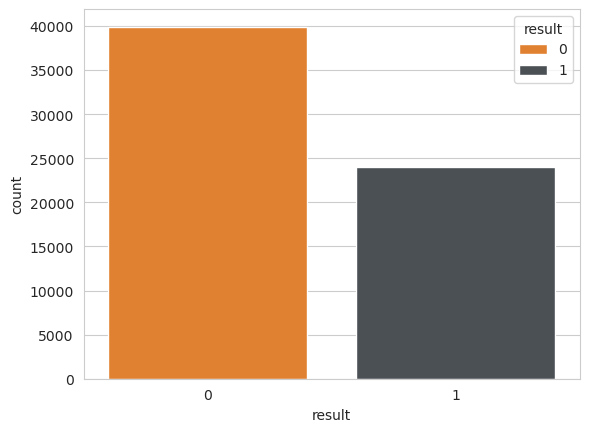

In [10]:
countplot(data=pd.DataFrame(train), x="result", palette=colors, hue="result");

Как видно на графике, присутствует дисбаланс в данных

**Переходим к обучению модели**

In [11]:
X = train["url"]
y = train["result"]

Извлечем фичи из ссылок

In [12]:
# def parse_url_features(urls):
#     results = []
#     for url in tqdm(urls):
#         parsed_url = urlparse(url)
#         features = {}
        
#         features['length'] = len(url)
#         features['num_subdomains'] = url.count('.')
#         features['num_dots'] = url.count('.')
#         features['is_https'] = 1 if parsed_url.scheme == 'https' else 0
#         features['path_length'] = len(parsed_url.path)
#         features['special_chars'] = 1 if any(char in url for char in ['#', '%', '&']) else 0
#         results.append(features)
    
#     return pd.DataFrame(results)

# features_dataframe = parse_url_features(X.to_list())

In [13]:
from nltk.tokenize import RegexpTokenizer

In [14]:
tokenizer = RegexpTokenizer(r'[\w\d]+')

In [15]:
tokenizer.tokenize(X[0])

['https', 'caseforpages1885777', 'web', 'app']

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
vectorizer = TfidfVectorizer(max_features=1024)

In [18]:
X_vec = vectorizer.fit_transform(X.apply(lambda x: ' '.join(tokenizer.tokenize(x))))

In [19]:
from catboost import CatBoostClassifier

In [20]:
random_state = 42

In [21]:
# Создание словаря с диапазонами значений для бустинга
param_grid_boosting = {
    'n_estimators': [50, 100, 150, 200], 
    'max_depth': range(3, 11), 
    'random_state': [random_state],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, 
    y, 
    random_state=42, 
    test_size=0.2, 
    shuffle=True
)

In [23]:
%%time
# Исчерпывающий поиск гиперпараметров по сетке (Grid Search) для CatBoostClassifier по заданным диапазонам значений 
gs = CatBoostClassifier(eval_metric='Accuracy', logging_level='Silent')
gs.grid_search(param_grid_boosting, X_train, y_train, stratified=True, verbose=False, plot=False)

CPU times: user 2h 17min 16s, sys: 6min 46s, total: 2h 24min 3s
Wall time: 1h 21min 12s


{'params': {'depth': 9,
  'random_seed': 42,
  'learning_rate': 0.2,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [26]:
# Обучение CatBoostClassifier с лучшими гиперпараметрами на всей обучающей выборке и подсчет метрики на тестовой выборке
model = CatBoostClassifier(**gs.get_params())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print(f'CatBoostClassifier: {(y_test, y_pred, average='macro')}')

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      8015
           1       0.92      0.86      0.89      4766

    accuracy                           0.92     12781
   macro avg       0.92      0.91      0.91     12781
weighted avg       0.92      0.92      0.92     12781



In [28]:
# Вывод лучших гиперпараметров
gs.get_params()

{'logging_level': 'Silent',
 'eval_metric': 'Accuracy',
 'depth': 9,
 'random_seed': 42,
 'learning_rate': 0.2,
 'iterations': 200}

In [29]:
# Обучение CatBoostClassifier с лучшими гиперпараметрами на всей обучающей выборке и подсчет метрики на тестовой выборке
model = CatBoostClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print(f'CatBoostClassifier: {(y_test, y_pred, average='macro')}')

Learning rate set to 0.055272
0:	learn: 0.6540297	total: 208ms	remaining: 3m 27s
1:	learn: 0.6213030	total: 668ms	remaining: 5m 33s
2:	learn: 0.5928119	total: 1.01s	remaining: 5m 36s
3:	learn: 0.5685721	total: 1.25s	remaining: 5m 11s
4:	learn: 0.5482415	total: 1.47s	remaining: 4m 53s
5:	learn: 0.5304134	total: 1.69s	remaining: 4m 40s
6:	learn: 0.5146886	total: 1.95s	remaining: 4m 36s
7:	learn: 0.5005845	total: 2.19s	remaining: 4m 31s
8:	learn: 0.4895348	total: 2.53s	remaining: 4m 38s
9:	learn: 0.4787019	total: 2.63s	remaining: 4m 20s
10:	learn: 0.4700702	total: 2.8s	remaining: 4m 11s
11:	learn: 0.4624150	total: 2.98s	remaining: 4m 5s
12:	learn: 0.4550777	total: 3.37s	remaining: 4m 16s
13:	learn: 0.4481414	total: 3.81s	remaining: 4m 28s
14:	learn: 0.4420800	total: 4.01s	remaining: 4m 23s
15:	learn: 0.4367121	total: 4.21s	remaining: 4m 18s
16:	learn: 0.4319747	total: 4.41s	remaining: 4m 15s
17:	learn: 0.4275966	total: 4.58s	remaining: 4m 9s
18:	learn: 0.4234491	total: 4.74s	remaining: 4m

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      8015
           1       0.92      0.86      0.89      4766

    accuracy                           0.92     12781
   macro avg       0.92      0.91      0.91     12781
weighted avg       0.92      0.92      0.92     12781

